201810824 현소미

1. DataFrame 생성

In [0]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [0]:
irisDf=spark.createDataFrame(iris)

In [0]:
irisDf.show()


+------------+-----------+------------+-----------+-----------+
sepal_length|sepal_width|petal_length|petal_width| species|
+------------+-----------+------------+-----------+-----------+
 5.1| 3.5| 1.4| 0.2|Iris-setosa|
 4.9| 3.0| 1.4| 0.2|Iris-setosa|
 4.7| 3.2| 1.3| 0.2|Iris-setosa|
 4.6| 3.1| 1.5| 0.2|Iris-setosa|
 5.0| 3.6| 1.4| 0.2|Iris-setosa|
 5.4| 3.9| 1.7| 0.4|Iris-setosa|
 4.6| 3.4| 1.4| 0.3|Iris-setosa|
 5.0| 3.4| 1.5| 0.2|Iris-setosa|
 4.4| 2.9| 1.4| 0.2|Iris-setosa|
 4.9| 3.1| 1.5| 0.1|Iris-setosa|
 5.4| 3.7| 1.5| 0.2|Iris-setosa|
 4.8| 3.4| 1.6| 0.2|Iris-setosa|
 4.8| 3.0| 1.4| 0.1|Iris-setosa|
 4.3| 3.0| 1.1| 0.1|Iris-setosa|
 5.8| 4.0| 1.2| 0.2|Iris-setosa|
 5.7| 4.4| 1.5| 0.4|Iris-setosa|
 5.4| 3.9| 1.3| 0.4|Iris-setosa|
 5.1| 3.5| 1.4| 0.3|Iris-setosa|
 5.7| 3.8| 1.7| 0.3|Iris-setosa|
 5.1| 3.8| 1.5| 0.3|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 20 rows

In [0]:
(trainDf, testDf)=irisDf.randomSplit([0.6,0.4])

In [0]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="species", outputCol="speciesIndex")

In [0]:
from pyspark.ml.feature import OneHotEncoder
encoder=OneHotEncoder(inputCol='speciesIndex', outputCol='speciesIndexVec')

In [0]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ["speciesIndexVec", "sepal_length",
"sepal_width","petal_width",'petal_length'],
                                   outputCol = 'features')

In [0]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='petal_width', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [0]:

from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer, encoder, va, lr])

In [0]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

3번데이터 회귀분석 후 계수 출력

In [0]:
print("Coefficients: {}".format(model.stages[-1].coefficients))

Coefficients: [0.0,0.0,0.0,0.0,0.45608089733512314,0.08118757216241479]

In [0]:
modelTestDf=model.transform(testDf)

4번 실제와 예측 출력

In [0]:
modelTestDf.select('petal_width','prediction').show(10)

+-----------+------------------+
petal_width| prediction|
+-----------+------------------+
 0.1| 0.482045957505271|
 0.2|0.5520103188875078|
 0.3|0.5976184086210201|
 0.2|0.5682478333199907|
 0.2|0.5520103188875078|
 0.2|0.5520103188875078|
 0.3|0.5976184086210201|
 0.2|0.5601290761037493|
 0.4|0.6675827700032568|
 0.4|0.6513452555707739|
+-----------+------------------+
only showing top 10 rows

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="rmse")

5번 정확성 평가

In [0]:

rmse=evaluator.evaluate(modelTestDf)

In [0]:
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

Out[46]: 'Root Mean Squared Error (RMSE) on test data: 0.287'

데이터와 예측값 그래프

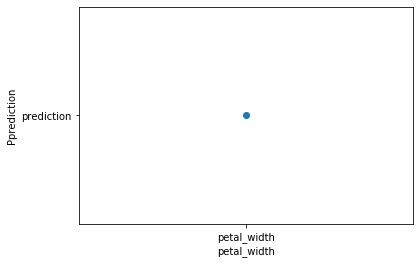

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter('petal_width','prediction')
ax.set_ylabel('Pprediction') 
ax.set_xlabel('petal_width')
ax.plot('petal_width','petal_width')